# Residual Connections in PyTorch

[link](https://ut.philkr.net/deeplearning/residuals_and_normalizations/residual_connections_in_pytorch/)

In [ ]:
import torch
import torch.nn as nn
import torchvision
from PIL import Image

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("mps")

In [3]:
class MLP(nn.Module):
    class SkipBlock(nn.Module):
        def __init__(self, in_dim,out_dim,activation=nn.ReLU()):
            super().__init__()
            self.linear = nn.Linear(in_dim, out_dim)
            if out_dim > 1:
                self.norm = nn.LayerNorm(out_dim)
            self.activation = activation
            if in_dim != out_dim:
                self.skip = nn.Linear(in_dim, out_dim)  
            else:
                self.skip = nn.Identity()

        def forward(self, x):
            out = self.linear(x)
            out = self.norm(out)
            out = self.activation(out)
            return out + self.skip(x)
    
    def __init__(self, input_dim, hidden_dims, output_dim,activation=nn.ReLU()):
        super().__init__()
        layers = [nn.Flatten()]
        in_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(self.SkipBlock(in_dim, h_dim,activation))
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim, bias=False))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

## Create Dataset

In [6]:
size = (128,128)
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(size),torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.Flowers102(root='../raw_data', split = 'train', download=True, transform=transform)
test_dataset = torchvision.datasets.Flowers102(root='../raw_data', split = 'test', download=True, transform=transform)

100%|██████████| 345M/345M [00:32<00:00, 10.6MB/s] 
100%|██████████| 502/502 [00:00<00:00, 715kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 5.95MB/s]


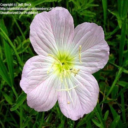

In [13]:
def visualize_image(img: torch.Tensor) -> Image.Image:
    return Image.fromarray((img.permute(1, 2, 0) * 255).to(torch.uint8).numpy())
visualize_image(train_dataset[1][0])

## Train

In [ ]:
lr = 0.001
momentum = 0.9
batch_size = 32
loss = torch.nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=len(test_dataset), shuffle=False)

In [15]:
torch.manual_seed(1)

model = MLP(input_dim=size[0]*size[1]*3,
            hidden_dims=[512,512,512],
            output_dim=102
        ).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

model.train()
losses = []
for epoch in range(30):
    for img,label in train_loader:
        img = img.to(device)
        label = label.to(device)
        pred_y = model(img)
        optimizer.zero_grad()
        loss_value = loss(pred_y, label)
        loss_value.backward()
        optimizer.step()
        losses.append(loss_value.item())
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, loss: {sum(losses)/len(losses)}")

Epoch 0, loss: 4.865208342671394
Epoch 1, loss: 4.509928986430168
Epoch 2, loss: 4.178961778680484
Epoch 3, loss: 3.8867015428841114
Epoch 4, loss: 3.626791277527809
Epoch 5, loss: 3.384694521004955
Epoch 6, loss: 3.172346508396523
Epoch 7, loss: 2.9830534090287983
Epoch 8, loss: 2.792089663859871
Epoch 9, loss: 2.6139552032575013
Epoch 10, loss: 2.4521750250661913
Epoch 11, loss: 2.3024124652147293
Epoch 12, loss: 2.1648392425850034
Epoch 13, loss: 2.0357866200418875
Epoch 14, loss: 1.9187288030671577
Epoch 15, loss: 1.8103296800691169
Epoch 16, loss: 1.711909889435286
Epoch 17, loss: 1.6220798739620175
Epoch 18, loss: 1.5405888958086602
Epoch 19, loss: 1.4661839055363088
Epoch 20, loss: 1.3981341533224276
Epoch 21, loss: 1.336023246932944
Epoch 22, loss: 1.2791038066877618
Epoch 23, loss: 1.226780831340875
Epoch 24, loss: 1.1785464448481797
Epoch 25, loss: 1.1339434918974383
Epoch 26, loss: 1.0925765738960493
Epoch 27, loss: 1.054121986390133
Epoch 28, loss: 1.0182743565639047
Epoch 

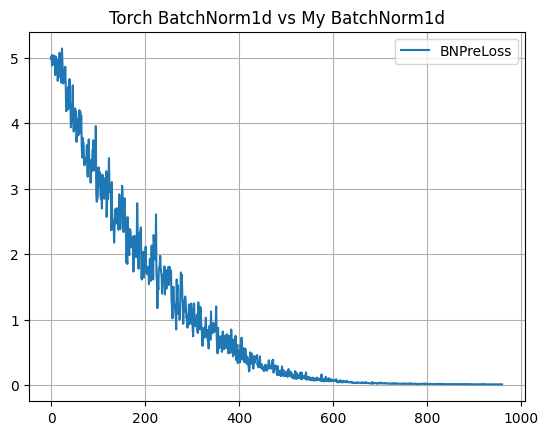

In [16]:
plt.plot(losses,linestyle="-",label="BNPreLoss")
plt.title(f"Torch BatchNorm1d vs My BatchNorm1d")
plt.grid(True)
plt.legend()
plt.show()

# Evaluation

In [17]:
for test_images, test_labels in test_loader:
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    prred_test = model(test_images)
    accuracy = ((prred_test.argmax(dim=1) == test_labels).float().mean()).item()
print(f"Test accuracy: {accuracy}")

Test accuracy: 0.1527077555656433
